In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import tiktoken

In [3]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [4]:
from utils.gpt import GPTModel
from utils.gptdataset import GPTDatasetV1, create_dataloader_v1
from utils.loss import calc_loss_batch, calc_loss_loader

from utils.generator import generate_text_simple
from utils.conversion import text_to_token_ids, token_ids_to_text

### Recap for parameters for GPT 2:

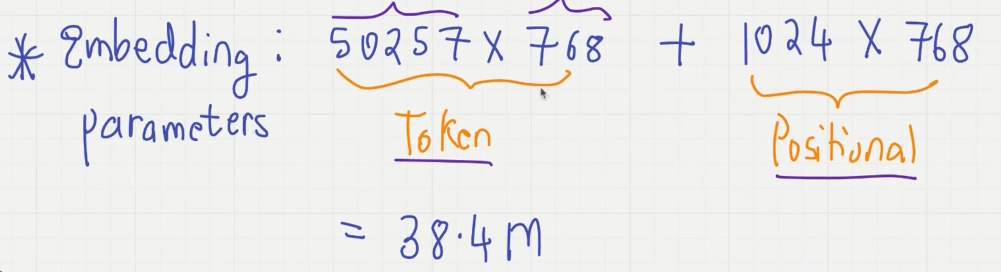

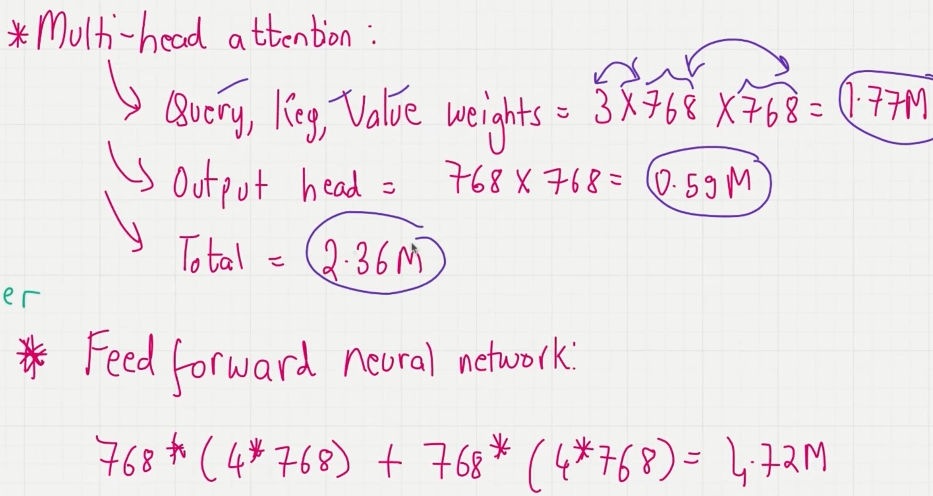

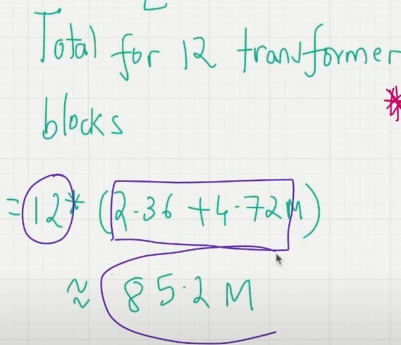

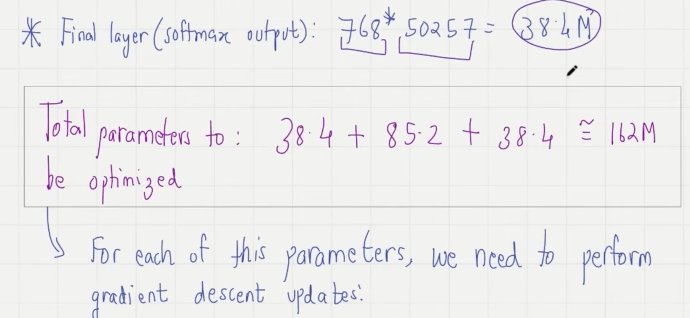

GPT 2 uses weight tying to make the parameters 124 M


## Load the dataset and initialize the model

1. Read the file and split the train and validation text data
2. Define the GPT config
3. Pass them to the `create_dataloader_v1` which creates train and val datasets and the train and val loaders
4. Initialize the model and optimizer


In [5]:
cwd_path = os.getcwd()
# print(cwd_path)

parent_path = os.path.join(cwd_path, '..')
# This is a relative path that conceptually points to the 
# parent directory of chap_5, which is LLM

relative_file_path = os.path.join(parent_path, 'data', 'the_verdict.txt') # This is still a relative path with .. in it.
# Conceptually, it means: “Start in chap_5, 
# go up one directory to LLM, then go into data, and find the_verdict.txt.”

file_path = os.path.abspath(relative_file_path) # This resolves the relative path to an absolute path.
# print(file_path)

'''
When we use os.path.join(cwd_path, '..'), we're telling Python to construct a path that goes up one directory level.
The .. remains in the path string until it's resolved by a function like 
os.path.abspath() or when the file system interprets the path (e.g., during open()).
'''

# Step 1
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()


train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# Step 2
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 256, # Context length # We shorten the context length from 1024 to 256 for faster training
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

torch.manual_seed(123)
# Step 3
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=4
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=4
)

In [6]:
# Step 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.0004, weight_decay=0.1
)

num_epochs = 10

## Typical Training loop in pytorch schematic

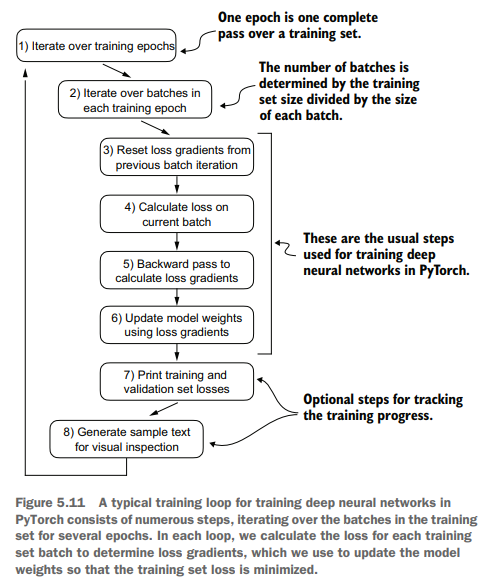

In [7]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):

    '''
    Evaluates the performance of a GPT-2 model by computing the average loss on a specified 
    number of batches from both the training and validation data loaders. This function is 
    used to assess the model's generalization during training without updating model parameters.  

    eval_iter: The number of batches to process from each loader to compute the average loss.
    '''

    # Set the model to evaluation mode, disabling dropout and other training-specific layers
    model.eval() 
    # Disables gradient tracking, which is not required during evaluation, to reduce
    # the computational overhead
    with torch.no_grad(): 
        # Calculate average training loss over a specified number of batches
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        # Calculate average validation loss over a specified number of batches
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    # Switch the model back to training mode
    model.train()
    # Return the computed training and validation losses
    return train_loss, val_loss

In [8]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    
    '''
    Generates a sample text sequence from the GPT-2 model given an initial context 
    and prints it. This function is used to qualitatively assess the model's text 
    generation capabilities during training. 
    '''
    # Set the model to evaluation mode for consistent text generation
    model.eval()
    
    # Retrieve the context size from the model's positional embedding layer
    context_size = model.pos_emb.weight.shape[0]
    
    # Encode the start context into token IDs and move to the specified device
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    
    # Disable gradient computation for efficiency during generation
    with torch.no_grad():
        # Generate a sequence of new tokens based on the encoded context
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    
    # Decode the generated token IDs back into text
    decoded_text = token_ids_to_text(token_ids, tokenizer)

    # Print the generated text, replacing newlines with spaces for readability
    print(decoded_text.replace("\n", " ")) 

    # Switch the model back to training mode
    model.train()

In [9]:
def train_model_simple(model, train_loader, val_loader,
    optimizer, device, num_epochs,
    eval_freq, eval_iter, start_context, tokenizer):

    '''
     Trains a GPT-2 model using a simple training loop over a specified number of epochs. 
     It processes batches from the training data, updates model parameters, periodically 
     evaluates the model on training and validation sets, generates sample text, and tracks losses and tokens processed.
    '''
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], [] 
    tokens_seen, global_step = 0, -1
    
    # Training loop
    for epoch in range(num_epochs): 
        model.train()

        for input_batch, target_batch in train_loader:
            # Reset loss gradients from previous batch iteration
            optimizer.zero_grad() 

            # Compute the loss for the current batch
            loss = calc_loss_batch(
                    input_batch, target_batch, model, device
                )
            
            # Backpropagate the loss to compute gradients
            loss.backward() 

            # Update model parameters using the computed gradients
            optimizer.step()
            # Track the total number of tokens processed (based on input batch size)
            tokens_seen += input_batch.numel()

            # Track total number of training steps (batches processed)
            global_step += 1
        
            # Periodically evaluate the model based on the evaluation frequency 
            if global_step % eval_freq == 0: 
                # Compute training and validation losses
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                
                # Append losses and tokens seen to their respective tracking lists
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                # Print the current epoch, step, and loss values
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                    )
                
        # Generate and print a sample text output after each epoch
        generate_and_print_sample( 
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

Key Differences from Other Training Loops

1. **Language Model Specifics**: GPT-2 is a transformer-based autoregressive language model, so the loop focuses on processing sequences of tokens, computing cross-entropy loss for next-token prediction, and generating text samples to qualitatively evaluate progress.

2. **Evaluation During Training**: The loop periodically evaluates the model on both training and validation sets within the training loop, which is less common in some simpler models where evaluation happens only after each epoch.

3. **Token Tracking**: Instead of just tracking epochs or batches, it tracks the total number of tokens processed, which is a common metric in language model training to account for variable sequence lengths.

4. **Text Generation**: The loop includes a function to generate and print sample text after each epoch, which is specific to generative models like GPT-2 to assess the quality of the model’s output.

5. **Global Step Counter**: It uses a global_step counter (incremented per batch) to trigger periodic evaluations, which is more flexible than epoch-based evaluation.

In [10]:
tokenizer = tiktoken.get_encoding("gpt2")

import time 
start_time = time.time()
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()

execution_time_seconds = (end_time - start_time)
print("------------------------------------------------------------")
print(f"Training completed in {execution_time_seconds:.2f} seconds")

Epoch 1 (Step 000000): Train loss 9.823, Val loss 9.927
Epoch 1 (Step 000005): Train loss 8.075, Val loss 8.340
Every effort moves you,,,,,,,,,,,,,,.                                   
Epoch 2 (Step 000010): Train loss 6.631, Val loss 7.051
Epoch 2 (Step 000015): Train loss 6.055, Val loss 6.604
Every effort moves you, and,, and,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 3 (Step 000020): Train loss 5.604, Val loss 6.469
Epoch 3 (Step 000025): Train loss 5.599, Val loss 6.458
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Epoch 4 (Step 000030): Train loss 5.282, Val loss 6.352
Epoch 4 (Step 000035): Train loss 5.027, Val loss 6.366
Every effort moves you know; and he had been. I had been the picture. Gisburn, and he had been, and he had been. I had the picture my a Jack himself, and he had been, and he had been, and he was a
Epoch 5 (Step 000040): Train loss 4.621, Val loss 6.297

We can observe (by comparing with "the_verdict.txt" ) that in the later epochs, the model is directly reciting text from data. So, it's literally just memorizing the data.

In [11]:
tokens_seen

[512,
 3072,
 5632,
 8192,
 10752,
 13312,
 15872,
 18432,
 20992,
 23552,
 26112,
 28672,
 31232,
 33792,
 36352,
 38912,
 41472,
 44032]

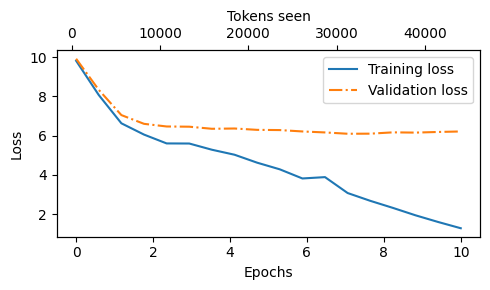

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


The number of tokens in the text is $5,000$ but here it shows roughly $50,000$. This actually makes sense since the model sees the same $5000$ tokens for $10$ epochs.

At the beginning of the training, both the training and validation set losses sharply decrease, which is a sign that the model is learning. However, the training set loss continues to decrease past the second epoch, whereas the validation loss stagnates. This is a sign that the model is still learning, but it’s **overfitting** to the training set past epoch $2$.


This memorization is expected since we are working with a very, very small training
dataset and training the model for multiple epochs. Usually, it’s common to train a
model on a much larger dataset for only one epoch.


### Saving the trained model weights

In [13]:
def save_model(model, model_save_name, optimizer = None, save_dir_name = 'models'):
    '''
    Saves the model's state dictionary to a directory name and file name 
    (creates the save_dir as an immediate sub-directory of project's root directory).
    model: The model to be saved.

    model_save_name: The name of the file where the model will be saved.

    optimizer: The optimizer to be saved. By default, it is None.
    
    save_dir_name: The name of the directory where the model will be saved. By default, it is 'models'.


    Optimizer is not saved by default, but it can be saved if needed (to resume training).

    Raises:
        FileExistsError: If the model file already exists.
    
    '''


    cwd_path = os.getcwd()
    # print(cwd_path)

    parent_path = os.path.join(cwd_path, '..')
    # This is a relative path that conceptually points to the 
    # parent directory of chap_5, which is LLM


    relative_save_dir_path = os.path.join(parent_path, save_dir_name) # This is still a relative path with .. in it.

    save_dir_path = os.path.abspath(relative_save_dir_path) # This resolves the relative path to an absolute path.
    # Ensure the directory exists
    os.makedirs(save_dir_path, exist_ok=True)

    save_path = os.path.join(save_dir_path, model_save_name)

    # Save the model state dictionary only if it doesn't already exist
    if os.path.exists(save_path):
        raise FileExistsError(f"Model already exists at {save_path}. \nPlease use a different name.")

    if optimizer is not None:
        # Save the model and optimizer state dictionaries
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, save_path)
        
    else:
        torch.save(model.state_dict(), save_path)



In [14]:
try:
    save_model(model, "naive_trained_model_with_opt.pth", optimizer=optimizer)
except FileExistsError as e:
    print(e)

If we plan to **continue pretraining a model later** —for example, using the `train_model_simple` function we defined earlier in this chapter—saving the **optimizer state** is also recommended.

Adaptive optimizers such as `AdamW` store additional parameters for each model
weight. `AdamW` uses historical data to adjust learning rates for each model parameter
dynamically. 

Without it, the optimizer resets, and the model may learn suboptimally or even fail to converge properly, which means it will lose the ability to generate coherent text. Using `torch.save`, we can save both the `model` and `optimizer state_dict` contents:

In [15]:
def load_model(model_obj, model_config, model_name, device, optimizer=None, load_dir_name='models'):
    '''
    Loads the model's state dictionary (and optionally the optimizer's) 
    from a given directory and file name.

    model_obj: The GPT model instance whose state will be loaded.
    
    model_config: The GPT configuration dictionary for the model. This is used to initialize the model.
    
    model_name: The name of the file where the model is saved.

    device: The device (CPU or GPU) on which the model will be loaded.

    optimizer: (Optional) The optimizer instance whose state will be loaded.
    
    load_dir_name: The directory name where the model is stored. Default is 'models'.

    Returns:
        model: The model with loaded state dict. (returns in evaluation mode if no optimizer is provided)
        optimizer: The optimizer with loaded state dict (if provided, model returns in train mode).
    '''

    cwd_path = os.getcwd()
    parent_path = os.path.join(cwd_path, '..')
    relative_load_dir_path = os.path.join(parent_path, load_dir_name)
    load_dir_path = os.path.abspath(relative_load_dir_path)
    load_path = os.path.join(load_dir_path, model_name)

    if not os.path.exists(load_path):
        raise FileNotFoundError(f"No model found at {load_path}")

    if optimizer is not None:
        # Load the model and optimizer state dictionaries
        checkpoint = torch.load(load_path, map_location = device)
        # Initialize the model with the provided configuration
        model = model_obj(model_config)

        # Load the model and optimizer state dictionaries
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        model.train() # Set the model to training mode
        return model, optimizer
    else:
        # Initialize the model with the provided configuration
        model = model_obj(model_config)
        # Load the model state dictionary
        model.load_state_dict(torch.load(load_path, map_location=device))

        model.eval() # Set the model to evaluation mode
        return model


In [16]:
load_model(GPTModel, GPT_CONFIG_124M, model_name = "naive_trained_model.pth", device = device)

FileNotFoundError: No model found at /home/mejan/projects/LLM/models/naive_trained_model.pth